<a href="https://colab.research.google.com/github/psygrammer/psypy_lm/blob/main/notebooks/ch02/02_fine_tuning_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Fine-Tuning BERT Models

* 싸이그래머 / 싸이파이 [1]
* 김무성

------------

# 차례
* The architecture of BERT
  - The encoder stack 
    - Preparing the pretraining input environment 
  - Pretraining and fine-tuning a BERT model
* Fine-tuning BERT
  - Activating the GPU
  - Installing the Hugging Face PyTorch interface for BERT
  - Importing the modules
  - Specifying CUDA as the device for torch
  - Loading the dataset
  - Creating sentences, label lists, and adding BERT tokens
  - Activating the BERT tokenizer
  - Processing the data
  - Creating attention masks 59 Splitting data into training and validation sets
  - Converting all the data into torch tensors
  - Selecting a batch size and creating an iterator
  - BERT model configuration
  - Loading the Hugging Face BERT uncased base model
  - Optimizer grouped parameters
  - The hyperparameters for the training loop
  - The training loop 66 Training evaluation
  - Predicting and evaluating using the holdout dataset
  - Evaluating using Matthews Correlation Coefficient
  - The score of individual batches
  - Matthews evaluation for the whole dataset
* Summary

-------------

In [2]:
!git clone https://github.com/psygrammer/psypy_lm.git

fatal: destination path 'psypy_lm' already exists and is not an empty directory.


In [3]:
ls

psypy_lm/  sample_data/


In [4]:
# change work_dir
%cd /content/psypy_lm/notebooks/ch02

/content/psypy_lm/notebooks/ch02


In [5]:
ls

02_fine_tuning_bert.ipynb  in_domain_train.tsv  out_of_domain_dev.tsv


-------------------

# The architecture of BERT
* The encoder stack 
  - Preparing the pretraining input environment 
* Pretraining and fine-tuning a BERT model


------------------

# Fine-tuning BERT
  - Activating the GPU
  - Installing the Hugging Face PyTorch interface for BERT
  - Importing the modules
  - Specifying CUDA as the device for torch
  - Loading the dataset
  - Creating sentences, label lists, and adding BERT tokens
  - Activating the BERT tokenizer
  - Processing the data
  - Creating attention masks 59 Splitting data into training and validation sets
  - Converting all the data into torch tensors
  - Selecting a batch size and creating an iterator
  - BERT model configuration
  - Loading the Hugging Face BERT uncased base model
  - Optimizer grouped parameters
  - The hyperparameters for the training loop
  - The training loop 66 Training evaluation
  - Predicting and evaluating using the holdout dataset
  - Evaluating using Matthews Correlation Coefficient
  - The score of individual batches
  - Matthews evaluation for the whole dataset


In [6]:
#@title Activating the GPU
# Main menu->Runtime->Change Runtime Type
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [7]:
 #@title Installing the Hugging Face PyTorch Interface for Bert
!pip install -q transformers

     |████████████████████████████████| 2.1MB 18.3MB/s 
     |████████████████████████████████| 3.3MB 48.0MB/s 
     |████████████████████████████████| 901kB 54.6MB/s 


In [8]:
#@title Importing the modules
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

In [9]:
from tqdm import tqdm, trange

In [10]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [11]:
#@title Specify CUDA as device for Torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [12]:
#@title Loading the Dataset
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None,
names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [13]:
df.sample(10)

,sentence_source,label,label_notes,sentence
7554,sks13,0,*,i heard john 's criticism of myself .
3687,ks08,1,NaN,no doubt that he was forced to leave his famil...
3918,ks08,0,*,the problem disappeared the accusation .
6630,m_02,1,NaN,flora cooks gourmet meals .
2383,l-93,1,NaN,the clown 's antics amused the children .
3414,l-93,0,*,the book valued at $ 200 .
7445,sks13,0,*,mary thinks whether bill will come .
8526,ad03,1,NaN,reading shakespeare satisfied me
373,bc01,1,NaN,the da proved jones guilty and the assistant d...
7000,sgww85,1,NaN,john sang beautifully .


In [14]:
#@ Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values

In [15]:
len(sentences)

8551

In [16]:
sentences

array(["our friends wo n't buy this analysis , let alone the next one we propose .",
       "one more pseudo generalization and i 'm giving up .",
       "one more pseudo generalization or i 'm giving up .", ...,
       'it is easy to slay the gorgon .',
       'i had the strangest feeling that i knew you .',
       'what all did you get for christmas ?'], dtype=object)

In [17]:
# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences] 
labels = df.label.values

In [18]:
sentences

["[CLS] our friends wo n't buy this analysis , let alone the next one we propose . [SEP]",
 "[CLS] one more pseudo generalization and i 'm giving up . [SEP]",
 "[CLS] one more pseudo generalization or i 'm giving up . [SEP]",
 '[CLS] the more we study verbs , the crazier they get . [SEP]',
 '[CLS] day by day the facts are getting murkier . [SEP]',
 "[CLS] i 'll fix you a drink . [SEP]",
 '[CLS] fred watered the plants flat . [SEP]',
 '[CLS] bill coughed his way out of the restaurant . [SEP]',
 "[CLS] we 're dancing the night away . [SEP]",
 '[CLS] herman hammered the metal flat . [SEP]',
 '[CLS] the critics laughed the play off the stage . [SEP]',
 '[CLS] the pond froze solid . [SEP]',
 '[CLS] bill rolled out of the room . [SEP]',
 '[CLS] the gardener watered the flowers flat . [SEP]',
 '[CLS] the gardener watered the flowers . [SEP]',
 '[CLS] bill broke the bathtub into pieces . [SEP]',
 '[CLS] bill broke the bathtub . [SEP]',
 '[CLS] they drank the pub dry . [SEP]',
 '[CLS] they dran

In [19]:
#@title Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [20]:
#@title Processing the data
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",truncating="post", padding="post")

In [21]:
input_ids

array([[ 101, 2256, 2814, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       ...,
       [ 101, 2009, 2003, ...,    0,    0,    0],
       [ 101, 1045, 2018, ...,    0,    0,    0],
       [ 101, 2054, 2035, ...,    0,    0,    0]])

In [22]:
#@title Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [23]:
attention_masks[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [24]:
#@title Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [25]:
#@title Converting all the data into torch tensors
# Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [26]:
#@title Selecting a Batch Size and Creating and Iterator
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [27]:
#@title Bert Configuration
# Initializing a BERT bert-base-uncased style configuration
#@title Transformer Installation
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers
  
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [28]:
#@title Loading the Hugging Face Bert Uncased Base Model 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [29]:
##@title Optimizer Grouped Parameters
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

In [30]:
#@title The Hyperparemeters for the Training Loop 
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [31]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
#@title The Training Loop
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5077459191385642


Epoch:  25%|██▌       | 1/4 [02:36<07:48, 156.15s/it]

Validation Accuracy: 0.8001543209876544
Train loss: 0.31403765113274584


Epoch:  50%|█████     | 2/4 [05:21<05:17, 158.90s/it]

Validation Accuracy: 0.8101851851851852
Train loss: 0.19072973558918815


Epoch:  75%|███████▌  | 3/4 [08:08<02:41, 161.22s/it]

Validation Accuracy: 0.8171296296296297
Train loss: 0.1331163230062273


Epoch: 100%|██████████| 4/4 [10:54<00:00, 163.68s/it]

Validation Accuracy: 0.8136574074074074


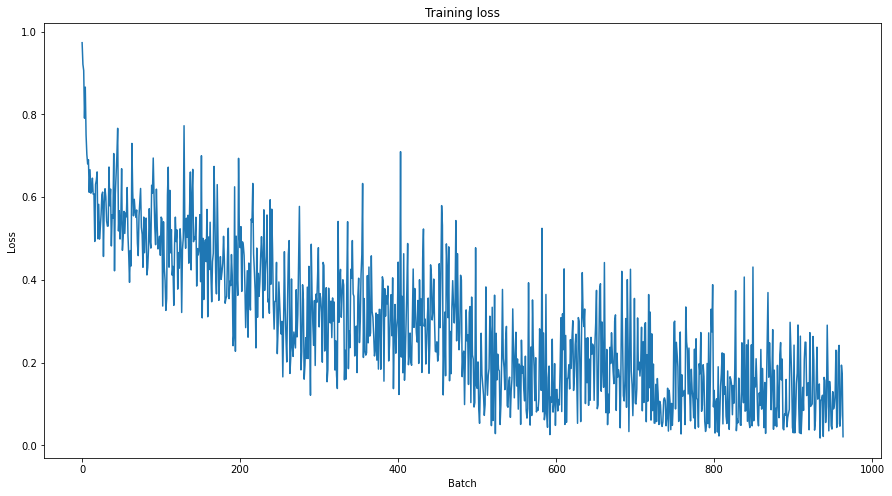

In [33]:
#@title Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [35]:
#@title Predicting and Evaluating Using the Hold-out Dataset 
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [36]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [37]:
#@title Evaluating Using Matthew's Correlation Coefficient
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [38]:
#@title Score of Individual Batches
matthews_set

[0.049286405809014416,
 -0.17407765595569785,
 0.4040950971038548,
 0.39405520311955033,
 0.5222329678670935,
 0.7410010097502685,
 0.4526019054848144,
 0.47519096331149147,
 0.8320502943378436,
 0.8126375006351424,
 0.8459051693633014,
 0.647150228929434,
 0.8749672939989046,
 0.7948717948717948,
 0.3268228676411533,
 0.5844155844155844,
 0.0]

In [39]:
#@title Matthew's Evaluation on the Whole Dataset
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.565524118894937

# Summary

-----------------


# 참고문헌
* [1] Transformers for Natural Language Processing - https://www.amazon.com/Transformers-Natural-Language-Processing-architectures-ebook/dp/B08S977X8K